# Example: Kernel-based Dynamics - Lorenz-63

- Author: Dr. Daning Huang
- Date: 12/12/2025

## Introduction

In the previous kernel example, we introduced the configuration of kernel models and the training procedure.  Due to its linearity, kernel methods are one of the simplest models for handling nonlinearity.  However, a subtle aspect in kernel is the need to choose its hyperparameters, such as the lengthscale and the ridge parameter.  In our [prior work](https://arxiv.org/abs/2512.17203), we show that choosing hyperparameters is critical for the accuracy of the model and, if the hyperparameters are chosen well, the kernel models could beat more sophisticated neural network models.

In this example, we look at the classical Lorenz-63 dynamics, and see how to tune the kernel hyperparameters via a validation procedure, as suggested in our prior work.

## Problem Setup

The usual imports:

In [1]:
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

from dymad.io import load_model
from dymad.losses import vpt_loss     # New loss
from dymad.models import DKMSK
from dymad.training import LinearTrainer
from dymad.utils import plot_cv_results, plot_trajectory, plot_multi_trajs, TrajectorySampler

We generate the data in a specific way.  To obtain a trajectory of length $N$, we start from a random initial condition, time integrate for $N+4000$ steps with a step size of $0.01$, and discard the first $4000$ steps.  This way ensures the trajectory to stay on the Lorenz attractor.

We generate a $8000$-step trajectory, and use the first $2048$ steps for training, the following two $2000$-step segments for validation, and discard the rest.  Then we also generate 50 $2000$-step trajectories for testing.

In [2]:
M = 2048  # Training
V = 2000  # Validation
t_grid = np.linspace(0, 120, 12000)  # Train+Valid, with extra 4000 for burn-in
t_pred = np.linspace(0, 60, 6000)    # Test, with extra 4000 for burn-in

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
def f(t, x):
    dxdt = np.zeros_like(x)
    dxdt[0] = sigma * (x[1] - x[0])
    dxdt[1] = x[0] * (rho - x[2]) - x[1]
    dxdt[2] = x[0] * x[1] - beta * x[2]
    return dxdt

In [ ]:
"""lor_data.yaml
dims:
  states: 3
  inputs: 0
  observations: 3

x0:
  kind: uniform
  params:
    bounds:
      - [-1.0, 1.0]
      - [-1.0, 1.0]
      - [-1.0, 1.0]

solver:
  method: RK45
  rtol: 1.0e-8
  atol: 1.0e-8

postprocess:
  n_skip: 4000    # Extra option to discard initial steps
  shift_t: true   # Reset initial time to 0 after discarding
"""

In [4]:
# Data generation
sampler = TrajectorySampler(f, config='lor_data.yaml')
ts, xs, ys = sampler.sample(t_grid, batch=1)

np.savez_compressed('./data/l63_train.npz', t=ts[0][:M], x=xs[0][:M])
np.savez_compressed('./data/l63_valid.npz', t=ts[0][:V],
                    x=np.array([xs[0][M:M+V], xs[0][M+V:M+2*V]]))

tt, xt, yt = sampler.sample(t_pred, batch=50)
np.savez_compressed('./data/l63_test.npz', t=tt, x=xt)

The training data is illustrated below, sketching the well-known Lorenz butterfly.

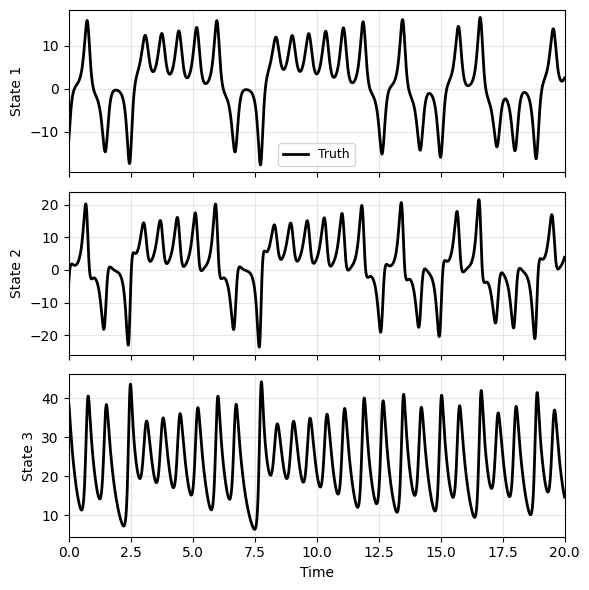

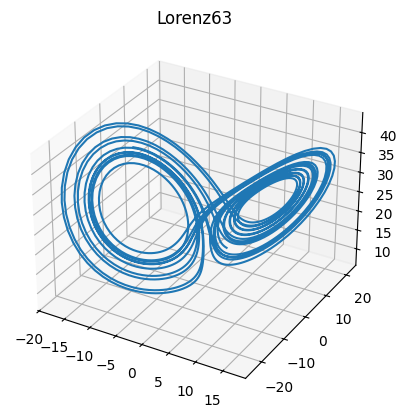

In [22]:
plot_trajectory(np.array(xs[0][:M]), ts[0][:M], None, labels=['Truth'], ifclose=False)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[0, :M, 0], xs[0, :M, 1], xs[0, :M, 2])
ax.set_title("Lorenz63");

## Configuring the Models

Next we set up the kernel models.  Here we consider the standard Gaussian radial basis function (RBF) and a data-driven kernel using the Diffusion Map (DM).

In [6]:
DIM = 3  # State dimension

# Configuration of kernels
opt_rbf = {
    "type": "sc_rbf",
    "input_dim": DIM,
    "lengthscale_init": None
}
opt_dm = {
    "type": "sc_dm",
    "input_dim": DIM,
    "eps_init": None,
}

# Configuration of KRR models
mdl_rbf = {
    "name" : 'ker_model',
    "encoder_layers" : 0,
    "decoder_layers" : 0,
    "kernel_dimension" : DIM,
    "type": "share",
    "kernel": opt_rbf,
    "dtype": torch.float64,
    "ridge_init": None,
    "jitter": 0.0
}
mdl_dm = copy.deepcopy(mdl_rbf)
mdl_dm["kernel"] = opt_dm

Next, we choose the standard linear trainer.

In [7]:
trn_ln = {
    "n_epochs": 1,
    "ls_update": {
        "method": "raw",
        "interval": 500,
        "times": 1}
        }

What is new here is that we add the validation in training.  Here we choose to sweep over a grid of the lengthscale and ridge parameters.  Lengthscales are sampled by a log scale, while ridge parameters are given individually.  The grid is sparse, and we will refine based on the initial results.

The chosen metric is VPT, meaning Valid Prediction Time.  This is the time up to which the error remains low, and is useful for chaotic dynamics where the long-term predictions are likely far off; wrong long-term predictions would produce large errors in standard metrics such as RMSE's, rendering the latter not indicative of model accuracy for chaotic dynamics.

> In `DyMAD` implementation, we use 1/VPT in the loss computation, so it remains positive and decreases as accuracy improves.

In [8]:
cv_rbf = {
    "param_grid": {
        "model.kernel.lengthscale_init": ('logspace', (1.0, 7.0, 12, True, 2)),
        "model.ridge_init": [1e-11, 1e-12, 1e-13]},
    "metric": "vpt"
}
cv_dm = {
    "param_grid": {
        "model.kernel.eps_init": ('logspace', (1.0, 7.0, 12, True, 2)),
        "model.ridge_init": [1e-11, 1e-12, 1e-13]},
    "metric": "vpt"
}

Paired with the above configuration is the model file.  Here we explicitly specify the training and validation datasets separately, and choose the criterion to VPT.  Note that by default the dynamics criterion, i.e., the error along a rollout trajectory, is always computed.

In [9]:
"""lor_model.yaml
data:
  path: './data/l63_train.npz'
  n_samples: 1
  n_steps: 2048
  double_precision: true

data_valid:
  path: './data/l63_valid.npz'
  n_samples: 2
  n_steps: 2000
  double_precision: true

transform_x:
  type: "scaler"
  mode: "std"

split:
  train_frac: 1.0

dataloader:
  batch_size: 1

criterion:
  vpt:
    type: "vpt"
    params:
      gamma: 0.3
"""
config_path = 'lor_model.yaml'

Collect the configurations:

In [10]:
cfgs = [
    ('ker_rbf', DKMSK,  LinearTrainer,     {"model": mdl_rbf, "cv": cv_rbf, "training" : trn_ln}),
    ('ker_dm',  DKMSK,  LinearTrainer,     {"model": mdl_dm,  "cv": cv_dm,  "training" : trn_ln}),
    ]

IDX = [0, 1]
labels = [cfgs[i][0] for i in IDX]

## Training and Validation
### Round 1
While training, you might be interested in monitoring the log for validation, where the results for each parameter combination are recorded.

In [11]:
for i in IDX:
    mdl, MDL, Trainer, opt = cfgs[i]
    opt["model"]["name"] = f"lor_{mdl}"
    trainer = Trainer(config_path, MDL, config_mod=opt)
    trainer.train()

After this round of training, let's plot the validation results and get an idea of the VPT distribution.  It appears that for both models, lower rigid is better, and RBF and DM have different best lengthscale.

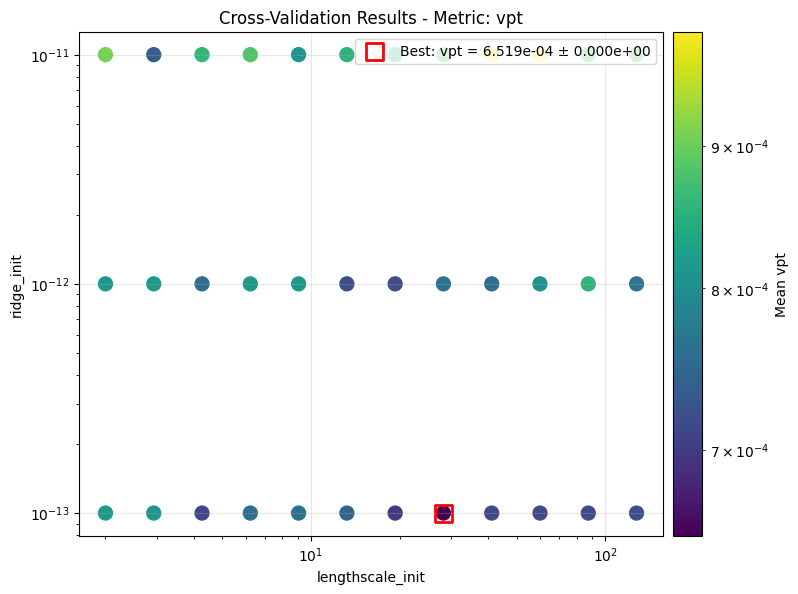

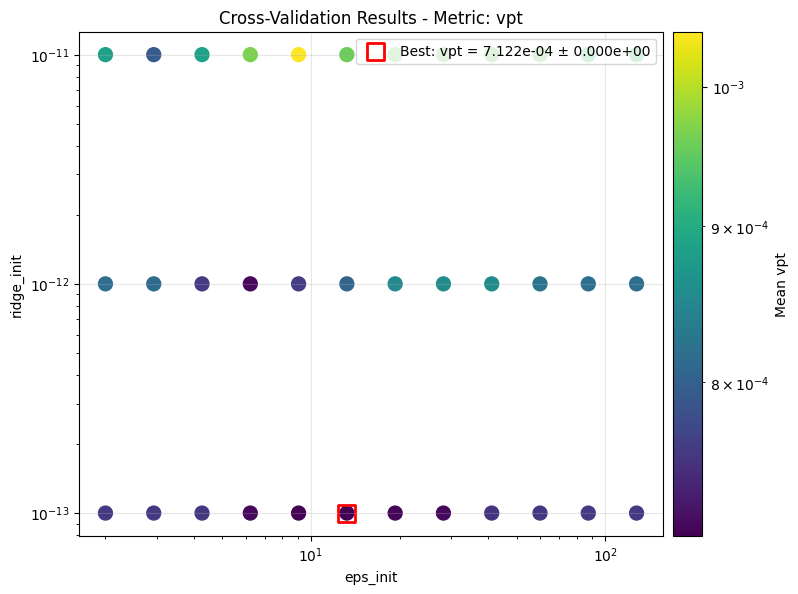

In [12]:
for i in IDX:
    mdl = cfgs[i][0]
    if i == 0:
        _key = 'model.kernel.lengthscale_init'
    else:
        _key = 'model.kernel.eps_init'
    keys = [_key, 'model.ridge_init']
    _, ax = plot_cv_results(f'lor_{mdl}', keys, ifclose=False)
    ax.set_xscale('log')
    ax.set_yscale('log')

### Round 2

Given the results, we modify the search range as follows, and train again.  During training, we set `continue_training=True`, so the indexing of the validation trials will continue from the previous results.

In [13]:
cv_rbf = {
    "param_grid": {
        "model.kernel.lengthscale_init": ('linspace', (20.0, 40.0, 20)),
        "model.ridge_init": [1e-13]},
    "metric": "vpt"
}
cv_dm = {
    "param_grid": {
        "model.kernel.eps_init": ('linspace', (10.0, 20.0, 10)),
        "model.ridge_init": [1e-13]},
    "metric": "vpt"
}
cfgs = [
    ('ker_rbf', DKMSK,  LinearTrainer,     {"model": mdl_rbf, "cv": cv_rbf, "training" : trn_ln}),
    ('ker_dm',  DKMSK,  LinearTrainer,     {"model": mdl_dm,  "cv": cv_dm,  "training" : trn_ln}),
    ]

In [14]:
for i in IDX:
    mdl, MDL, Trainer, opt = cfgs[i]
    opt["model"]["name"] = f"lor_{mdl}"
    trainer = Trainer(config_path, MDL, config_mod=opt)
    trainer.train(continue_training=True)  # Option to recycle previous results

Then we plot the validation results again.  Note that we only plot against the lengthscales, so some points from the previous trials are overlapping.

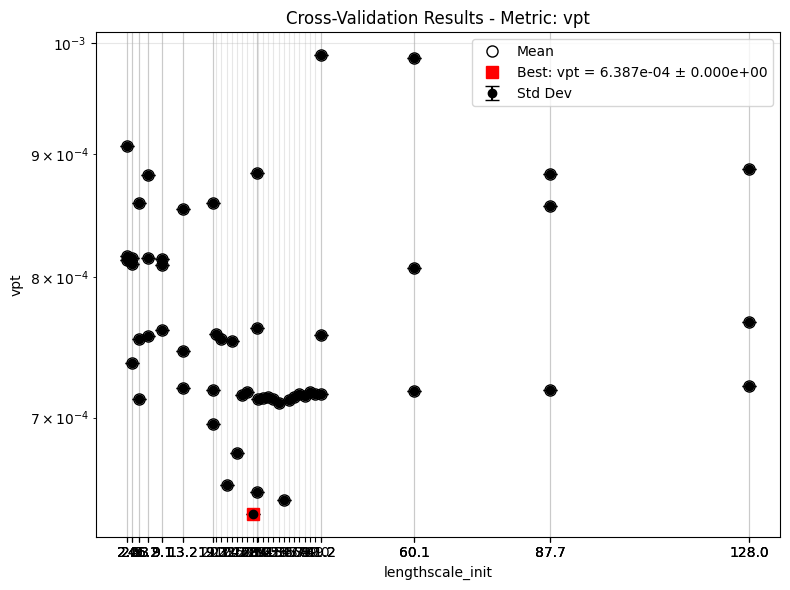

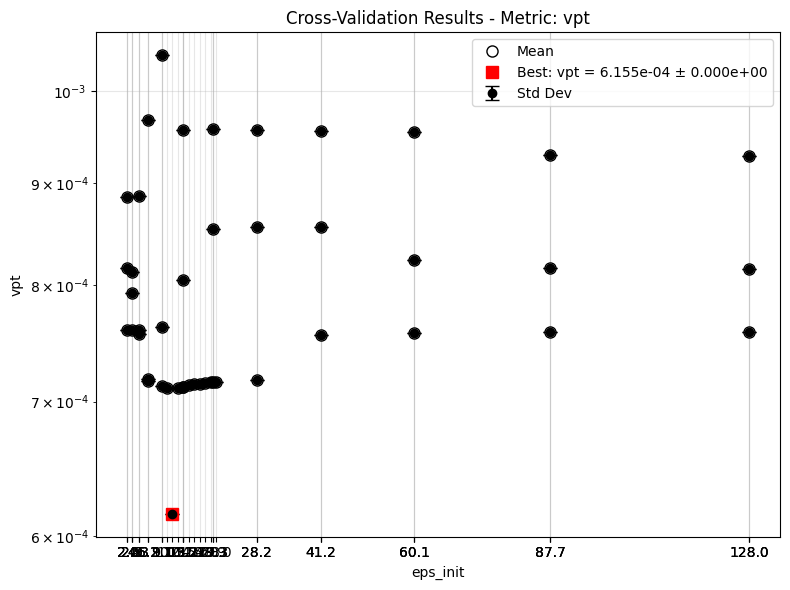

In [15]:
for i in IDX:
    mdl = cfgs[i][0]
    if i == 0:
        _key = 'model.kernel.lengthscale_init'
    else:
        _key = 'model.kernel.eps_init'
    _, ax = plot_cv_results(f'lor_{mdl}', [_key], ifclose=False)
    ax.set_yscale('log')

## Results

Lastly we make predictions on the new data, and plot two of the trajectories.  We see that both models give fairly long VPT.

In [16]:
data = np.load('./data/l63_test.npz')
ts = torch.tensor(data['t'], dtype=torch.float64)
xs = torch.tensor(data['x'], dtype=torch.float64)
JDX = 50

res = [xs[:JDX]]
for _i in IDX:
    mdl, MDL, _, _ = cfgs[_i]
    _, prd_func = load_model(MDL, f'lor_{mdl}.pt')
    with torch.no_grad():
        pred = prd_func(xs[:JDX], ts[:JDX])
    res.append(pred)

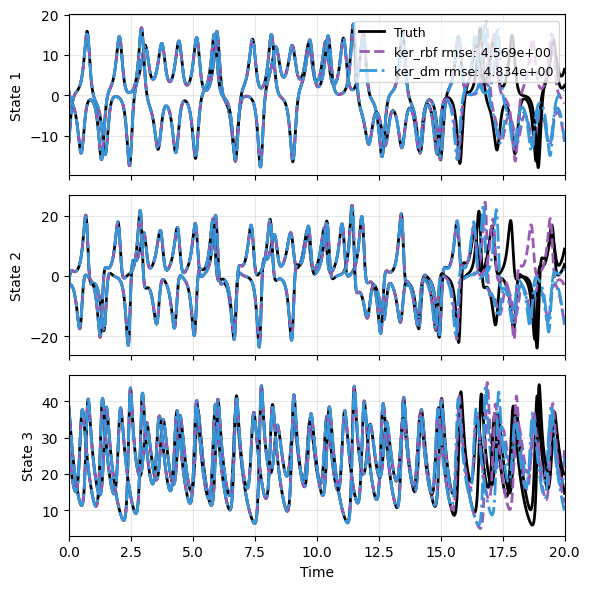

In [17]:
plot_multi_trajs(
    np.array([r[:2] for r in res]), ts[0], "L63",
    labels=['Truth']+labels, ifclose=False)

For a better characterization of the VPT distribution, we can use the violin plot of the VPT.  Below `vpt_loss` is a handy function for computing the VPT.

We note that DM appears to be better than RBF, with higher mean and smaller spread.  Intuitively, this is because of the capability of DM to capture the geometry of the Lorenz attractor, whose intrinsic dimension (about 2.06) is lower than the ambient dimension (3).

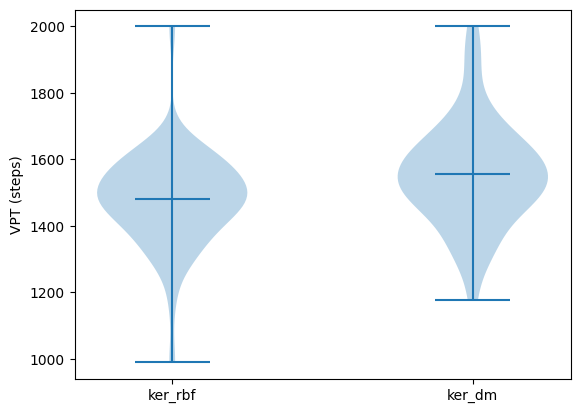

In [23]:
vpt_rb, avr_rb = vpt_loss(res[1], res[0], gamma=0.3)
vpt_dm, avr_dm = vpt_loss(res[2], res[0], gamma=0.3)

f = plt.figure()
plt.violinplot([vpt_rb, vpt_dm], showmeans=True)
plt.xticks([1, 2], labels)
plt.ylabel("VPT (steps)");